# <center> Competição Kaggle - Top Vistos

## Informações da competição

### Contexto:

As comunidades empresariais nos Estados Unidos enfrentam uma alta demanda por recursos humanos, mas um dos desafios constantes é identificar e atrair o talento certo, que é talvez o elemento mais importante para se manter competitivo. Empresas nos Estados Unidos procuram indivíduos trabalhadores, talentosos e qualificados tanto localmente quanto no exterior.

A Lei de Imigração e Nacionalidade (INA) dos EUA permite que trabalhadores estrangeiros venham trabalhar nos Estados Unidos temporária ou permanentemente. A lei também protege os trabalhadores americanos contra impactos adversos em seus salários ou condições de trabalho, garantindo que os empregadores americanos cumpram os requisitos legais ao contratar trabalhadores estrangeiros para suprir a escassez de mão de obra. Os programas de imigração são administrados pelo Escritório de Certificação de Trabalho Estrangeiro (OFLC).

O OFLC processa pedidos de certificação de emprego para empregadores que buscam trazer trabalhadores estrangeiros para os Estados Unidos e concede certificações nos casos em que os empregadores podem demonstrar que não há trabalhadores americanos suficientes disponíveis para realizar o trabalho com salários que atendam ou excedam o salário pago para a ocupação na área de emprego pretendida.

### Objetivo:

No ano fiscal de 2016, o OFLC processou 775.979 pedidos de empregadores para 1.699.957 posições de certificações de trabalho temporárias e permanentes. Isso representou um aumento de nove por cento no número total de pedidos processados em relação ao ano anterior. O processo de revisar cada caso está se tornando uma tarefa tediosa à medida que o número de candidatos aumenta a cada ano.

O aumento do número de candidatos a cada ano demanda uma solução baseada em Aprendizado de Máquina que possa ajudar na pré-seleção dos candidatos com maiores chances de aprovação de VISTO. O OFLC contratou sua empresa, TopVistos, para soluções baseadas em dados. Como Cientista de Dados, você deve analisar os dados fornecidos e, com a ajuda de um modelo de classificação:

- Facilitar o processo de aprovação de vistos.

- Recomendar um perfil adequado para os candidatos para os quais o visto deve ser certificado ou negado, com base nos fatores que influenciam significativamente o status do caso.

### Descrição do Conjunto de Dados

Os dados contêm diferentes atributos do empregado e do empregador. O dicionário de dados detalhado é fornecido abaixo.

Temos alguns arquivos disponibilizados para o treino dos modelos. Note que para seu modelo ser corretamente avaliado, você precisa enviar os seus dados no formato do arquivo sample_submission.csv.

### Arquivos

- train.csv - dataset de treino
- test.csv - dataset de testes
- sample_submission.csv - um exemplo de como o arquivo enviado deve ser composto

### Dicionário dos Dados

- id_do_caso: ID de cada solicitação de visto
- continente: Informação do continente do empregado
- educação_do_empregado: Informação sobre a educação do empregado
- tem_experiência_de_trabalho: O empregado possui alguma experiência de trabalho? S = Sim; N = Não
- requer_treinamento_de_trabalho: O empregado requer algum treinamento de trabalho? S = Sim; N = Não
- num_de_empregados: Número de funcionários na empresa do empregador
- ano_de_estabelecimento: Ano em que a empresa do empregador foi estabelecida
- região_de_emprego: Informação da região de emprego pretendida pelo trabalhador estrangeiro nos EUA.
- salário_prevalecente: Salário médio pago a trabalhadores em ocupações semelhantes na área de emprego pretendida. O objetivo do salário prevalecente é garantir que o trabalhador estrangeiro não seja subremunerado em comparação com outros trabalhadores que oferecem o mesmo serviço ou serviço similar na mesma área de emprego.
- unidade_de_salário: Unidade do salário prevalecente. Os valores incluem Por Hora, Por Semana, Por Mês e Por Ano.
- posição_em_tempo_integral: A posição de trabalho é em tempo integral? S = Posição em Tempo Integral; N = Posição em Meio Período
- status_do_caso: Indicador se o visto foi certificado ou negado

## Pré-processamento

### Importação das bibliotecas

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
import math
import unidecode

### Alteração de configuração de display do pandas

In [3]:
pd.options.display.float_format = "{:,.4f}".format

### Importação das bases de dados

In [4]:
df_train = pd.read_csv(r"..\Databases\train.csv")
df_test = pd.read_csv(r"..\Databases\test.csv")
df_submission = pd.read_csv(r"..\Databases\sample_submission.csv")

### Anualização do salário prevalecente

Considerando que a base apresenta os salários prevalecentes em escalas diferentes, foi necessário normalizá-los para que as informações sejam condizentes. Para isso, foram utilizados como padrão de anualização da unidade salarial as seguintes constantes:

- Ano: 1, pois já é o próprio valor anualizado
- Mês: 12, pois é o número de meses em 1 ano
- Semana: 52, pois é o número aproximado de semanas em 1 ano
- Hora: 2080, pois é o número de horas trabalhadas em média por semana (40 horas) multiplicado pelo número de semanas (52 semanas)

Os trabalhos que são full-time ou part-time aparentam demonstrar o valor de salário prevalecente já considerando a escala de trabalho e, por esta razão, não foram divididos por 2 para normalizar com a carga full-time.

In [5]:
dictionary_unidadesalario = {'Ano':1, 'Semana':52, 'Hora':2080, 'Mês':12}

In [6]:
lista_salario_anual = []

for row in range(df_train.shape[0]):
    lista_salario_anual.append(round(dictionary_unidadesalario[df_train.unidade_de_salario[row]] * df_train.salario_prevalecente[row], 2))

In [7]:
df_train["salario_prevalecente_anualizado"] = lista_salario_anual

### Segregação das bases de modelo das bases descritivas

Para facilitar a análise da estatística descritiva e da execução do modelo de Machine Learning, foram segregadas em duas bases que foram processadas de forma diferencia. As bases com sufixo "desc" representam as bases de estatística descritiva e mantêm os dados em seus formatos originais. Já as bases sem sufixo representam as bases que serão processadas no modelo e têm diversos tipos de manipulação de dados para adequá-los e facilitar o processamento.

In [8]:
df_train_descritiva = df_train.copy(deep = True)
df_test_descritiva = df_test.copy(deep = True)

### Limpeza de caracteres especiais e letras maiúsculas

In [9]:
def clean_text(x):
    return unidecode.unidecode(x).lower()

In [10]:
list_variaveis_a_limpar = ["id_do_caso", "continente", "educacao_do_empregado", "regiao_de_emprego", "unidade_de_salario"]

In [11]:
for column in list_variaveis_a_limpar:
    df_train[column] = df_train[column].apply(clean_text)

### Transformação em variáveis booleanas

In [12]:
list_variaveis_bool = ["tem_experiencia_de_trabalho", "requer_treinamento_de_trabalho", "posicao_em_tempo_integral", "status_do_caso"]

In [13]:
def convert_to_bool(x):
    if x == "N" or x == "Negado":
        return False
    else:
        return True

In [14]:
for column in list_variaveis_bool:
    df_train[column] = df_train[column].apply(convert_to_bool)

### Transformando variável categórica ordinal

In [15]:
dict_nivel_educacao = {'ensino medio':1.00, 'mestrado':3.00, 'ensino superior':2.00, 'doutorado':4.00}

In [16]:
def convert_nivel_educacao(x):
    return dict_nivel_educacao[x]

In [17]:
df_train["educacao_do_empregado"] = df_train["educacao_do_empregado"].apply(convert_nivel_educacao)

### Transformando em dummies

In [18]:
lista_variaveis_dummies = ["continente", "regiao_de_emprego", "unidade_de_salario"]

In [19]:
for column in lista_variaveis_dummies:
    df_train = pd.concat([df_train, pd.get_dummies(df_train[column])], axis = 1)
    df_train = df_train.drop(column, axis = 1)

### Transformando em float

In [20]:
lista_variaveis_float = ["educacao_do_empregado", "num_de_empregados", "salario_prevalecente", "ano_de_estabelecimento"]

In [21]:
for column in lista_variaveis_float:
    df_train[column] = df_train[column].apply(float)

## Estatística Descritiva

### Revisando os tipos de dados

In [22]:
print(f"A variável id_do_caso contém um valor único para cada variável? {len(df_train_descritiva.id_do_caso.unique()) == len(df_train_descritiva.id_do_caso)}")

A variável id_do_caso contém um valor único para cada variável? True


Os tipos de dados são:

|Variável|Tipo de dado|Formato Original|Formato Processado|Único por registro?|Tipo de variável|
|---|---|---|---|---|---|
|id_do_caso|Categórico Nominal|Texto|Texto|Sim|Índice|
|continente|Categórico Nominal|Texto|Texto|Não|Independente|
|educacao_do_empregado|Categórico Ordinal|Texto|Inteiro|Não|Independente|
|tem_experiencia_de_trabalho|Categórico Nominal|Texto|Binário|Não|Independente|
|requer_treinamento_de_trabalho|Categórico Nominal|Texto|Binário|Não|Independente|
|num_de_empregados|Numérico Discreto|Inteiro|Float|Não|Independente|
|ano_de_estabelecimento|Numérico Discreto|Inteiro|Float|Não|Independente|
|regiao_de_emprego|Categórico Nominal|Texto|Texto|Não|Independente|
|salario_prevalecente|Numérico Contínuo|Float|Float|Não|Independente|
|unidade_de_salario|Categórico Nominal|Texto|Texto|Não|Independente|
|posicao_em_tempo_integral|Categórico Nominal|Texto|Binário|Não|Independente|
|status_do_caso|Categórico Nominal|Texto|Binário|Não|Dependente|


Os dados derivados das informações iniciais são:

|Variável|Tipo de dado|Processamento|Formato Processado|Único por registro?|Tipo de variável|
|---|---|---|---|---|---|
|salario_prevalecente_anualizado|Numérico Contínuo|salario_prevalecente*(unidade_de_salario em anos)|Float|Não|Independente

### Informações básicas das variáveis

Primeiramente, vamos extrair algumas estatísticas básicas das variáveis quantitativas. Conforme podemos verificar por meio da tabela abaixo:
- O desvio-padrão do número de empregados é bem alto. Provavelmente há alguns outliers superiores, o que está gerando uma assimetria neste dado. Esta informação é corroborada pelo fato de que a mediana é menos da metade da média;
- Existe pelo menos 1 empresa com número de empregados negativo. É importante analisar mais profundamente esta informação pois, considerando que número de empregados é uma contagem, não é possível ter um número de empregados negativo;
- As variáveis de salário prevalecente e salário prevalecente anualizado possuem um valor muito baixo para ser um salário, seja hora ou seja anual. É importante revisar este valor, pois aparenta ser um problema de digitação;
- O maior salário é no valor de US$ 12 milhões, o que deve ser um erro de digitação.

In [23]:
df_train_descritiva.describe()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente,salario_prevalecente_anualizado
count,"17,836.0000","17,836.0000","17,836.0000","17,836.0000"
mean,"5,726.5019","1,979.4949","74,327.4284","196,512.9994"
std,"23,321.3774",42.0972,"52,795.8596","567,460.8820"
min,-26.0000,"1,800.0000",2.1367,115.8100
25%,"1,023.0000","1,976.0000","33,892.9125","46,681.8450"
50%,"2,117.0000","1,997.0000","70,106.9200","82,462.4450"
75%,"3,504.2500","2,005.0000","107,564.7150","124,664.9850"
max,"602,069.0000","2,016.0000","319,210.2700","12,189,130.7200"


Podemos realizar a mesma análise, porém agora apenas para os profissionais que foram aprovados:
- Continuamos encontrando um desvio-padrão maior que a média no número de empregados, o que indica outlier superior;
- Continuamos encontrando o número negativo de empregados;
- Continuamos encontrando um salário prevalecente muito baixo que pode ser indicativo de problema de digitação;
- Continuamos encontrando um salário prevalecente máximo muito alto que pode ser indicativo de problema de digitação;

In [24]:
df_train_descritiva[df_train_descritiva["status_do_caso"] == "Aprovado"].describe()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente,salario_prevalecente_anualizado
count,"11,937.0000","11,937.0000","11,937.0000","11,937.0000"
mean,"5,760.3480","1,979.7783","77,051.6792","161,565.8938"
std,"23,022.4687",42.1134,"52,123.5167","534,156.5318"
min,-26.0000,"1,800.0000",2.1367,115.8100
25%,"1,032.0000","1,976.0000","38,018.0500","44,441.8600"
50%,"2,147.0000","1,997.0000","72,274.9500","78,791.1200"
75%,"3,560.0000","2,005.0000","108,648.2600","117,397.6600"
max,"602,069.0000","2,016.0000","318,446.0500","12,189,130.7200"


Podemos realizar a mesma análise, porém agora apenas para os profissionais que foram negados:
- Continuamos encontrando um desvio-padrão maior que a média no número de empregados, o que indica outlier superior;
- Continuamos encontrando o número negativo de empregados;
- Continuamos encontrando um salário prevalecente muito baixo que pode ser indicativo de problema de digitação;
- Continuamos encontrando um salário prevalecente máximo muito alto que pode ser indicativo de problema de digitação;

In [25]:
df_train_descritiva[df_train_descritiva["status_do_caso"] == "Negado"].describe()

,num_de_empregados,ano_de_estabelecimento,salario_prevalecente,salario_prevalecente_anualizado
count,"5,899.0000","5,899.0000","5,899.0000","5,899.0000"
mean,"5,658.0120","1,978.9213","68,814.7344","267,230.6802"
std,"23,916.6432",42.0621,"53,714.2250","623,571.1600"
min,-26.0000,"1,800.0000",2.9561,153.1100
25%,995.5000,"1,975.0000","24,221.2100","51,978.3100"
50%,"2,067.0000","1,997.0000","65,782.6900","91,806.6600"
75%,"3,403.5000","2,004.0000","105,318.1150","144,163.4300"
max,"594,472.0000","2,016.0000","319,210.2700","8,854,281.8000"


Realizando uma análise gráfica do histograma das variáveis numéricas, podemos identificar que:
- As variáveis número de empregados e salário prevalecente anualizado são assimétricas à direita;
- A variável ano de estabelecimento é assimétrica à esquerda;
- Existem outliers que estão puxando as curvas de forma absurda, principalmente para as variáveis número de empregados e salário prevalecente anualizado;
- As distribuições destas variáveis não apresentam grande diferenciação quando comparadas as pessoas dos casos aprovados e dos negados;

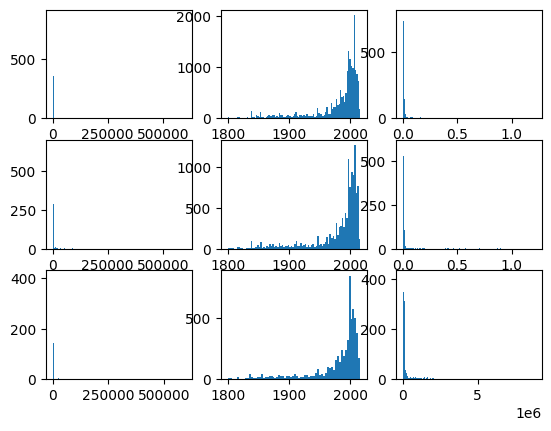

In [35]:
fig, axs = plt.subplots(3, 3, sharex = False, sharey = False)

axs[0,0].hist(df_train_descritiva["num_de_empregados"], bins = "auto")
axs[1,0].hist(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Aprovado"]["num_de_empregados"], bins = "auto")
axs[2,0].hist(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Negado"]["num_de_empregados"], bins = "auto")

axs[0,1].hist(df_train_descritiva["ano_de_estabelecimento"], bins = "auto")
axs[1,1].hist(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Aprovado"]["ano_de_estabelecimento"], bins = "auto")
axs[2,1].hist(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Negado"]["ano_de_estabelecimento"], bins = "auto")

axs[0,2].hist(df_train_descritiva["salario_prevalecente_anualizado"], bins = "auto")
axs[1,2].hist(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Aprovado"]["salario_prevalecente_anualizado"], bins = "auto")
axs[2,2].hist(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Negado"]["salario_prevalecente_anualizado"], bins = "auto")

plt.show()

Realizando uma análise gráfica do boxplot das variáveis numéricas, podemos identificar que:
- As variáveis número de empregados e salário prevalecente anualizado são assimétricas à direita;
- A variável ano de estabelecimento é assimétrica à esquerda;
- Todas as variáveis possuem muitos outliers;
- As distribuições destas variáveis não apresentam grande diferenciação quando comparadas as pessoas dos casos aprovados e dos negados;

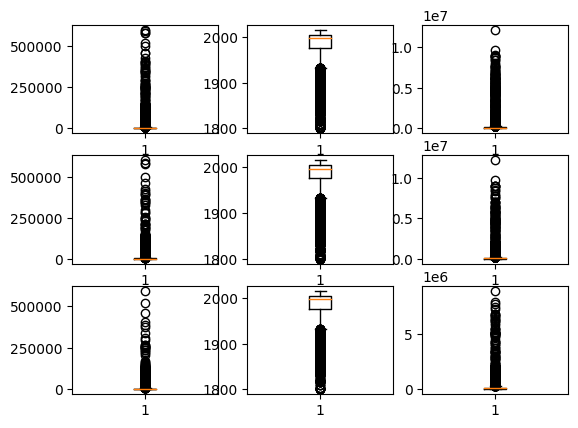

In [38]:
fig, axs = plt.subplots(3, 3, sharex = False, sharey = False)

axs[0,0].boxplot(df_train_descritiva["num_de_empregados"])
axs[1,0].boxplot(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Aprovado"]["num_de_empregados"])
axs[2,0].boxplot(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Negado"]["num_de_empregados"])

axs[0,1].boxplot(df_train_descritiva["ano_de_estabelecimento"])
axs[1,1].boxplot(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Aprovado"]["ano_de_estabelecimento"])
axs[2,1].boxplot(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Negado"]["ano_de_estabelecimento"])

axs[0,2].boxplot(df_train_descritiva["salario_prevalecente_anualizado"])
axs[1,2].boxplot(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Aprovado"]["salario_prevalecente_anualizado"])
axs[2,2].boxplot(df_train_descritiva[df_train_descritiva["status_do_caso"] == "Negado"]["salario_prevalecente_anualizado"])

plt.show()

In [74]:
df_train_descritiva.loc[(df_train_descritiva["salario_prevalecente_anualizado"] > 1000000) & (df_train_descritiva["status_do_caso"] == "Aprovado")]

,id_do_caso,continente,educacao_do_empregado,tem_experiencia_de_trabalho,requer_treinamento_de_trabalho,num_de_empregados,ano_de_estabelecimento,regiao_de_emprego,salario_prevalecente,unidade_de_salario,posicao_em_tempo_integral,status_do_caso,salario_prevalecente_anualizado
110,EZYV1213,Ásia,Ensino Médio,N,N,31859,1964,Sul,932.9804,Hora,S,Aprovado,"1,940,599.2300"
148,EZYV6563,Ásia,Mestrado,N,N,1383,2004,Meio-Oeste,718.0270,Hora,S,Aprovado,"1,493,496.1600"
196,EZYV8947,Oceania,Ensino Médio,N,N,4268,1962,Nordeste,853.6152,Hora,S,Aprovado,"1,775,519.6200"
254,EZYV22035,Ásia,Ensino Médio,S,N,2769,2012,Oeste,"37,185.3800",Semana,S,Aprovado,"1,933,639.7600"
310,EZYV8304,Europa,Mestrado,S,N,792,2007,Nordeste,855.9094,Hora,S,Aprovado,"1,780,291.5500"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17572,EZYV8889,Ásia,Mestrado,S,N,2547,1962,Sul,"144,234.8600",Semana,S,Aprovado,"7,500,212.7200"
17606,EZYV11510,América do Norte,Ensino Superior,S,N,90532,1948,Nordeste,"89,731.5600",Semana,S,Aprovado,"4,666,041.1200"
17633,EZYV20248,Europa,Mestrado,S,N,3100,1998,Nordeste,"127,991.5000",Semana,S,Aprovado,"6,655,558.0000"
17640,EZYV17068,Ásia,Ensino Superior,S,N,355,1838,Oeste,"157,009.8700",Mês,S,Aprovado,"1,884,118.4400"


In [65]:
df_train_descritiva.loc(["salario_prevalecente_anualizado"] > 1000000)

TypeError: '>' not supported between instances of 'list' and 'int'

Em seguida, vamos analisar a ocorrência das variáveis categóricas:

In [40]:
def show_summarized_ocurrences(df, x, count_column, y_column, y_filter1, y_filter2):
    return df[[x, count_column]].groupby(x).count().reset_index().rename({count_column:"total"}, axis = 1).merge(df[df[y_column] == y_filter1][[x, count_column]].groupby(x).count().reset_index().rename({count_column:"negados"}, axis = 1), on = x).merge(df[df[y_column] == y_filter2][[x, count_column]].groupby(x).count().reset_index().rename({count_column:"aprovados"}, axis = 1), on = x)

In [50]:
def show_percentage_ocurrences(df):
    df["perc_negados"] = df.negados / df.total
    df["perc_aprovados"] = df.aprovados / df.total    
    return df

In [51]:
def show_summarized_percentage_ocurrences(df, x, count_column, y_column, y_filter1, y_filter2):
    df = show_summarized_ocurrences(df, x, count_column, y_column, y_filter1, y_filter2)
    df = show_percentage_ocurrences(df)
    return df

In [52]:
show_summarized_percentage_ocurrences(df = df_train_descritiva, 
                           x = "continente", 
                           count_column = "id_do_caso", 
                           y_column = "status_do_caso", 
                           y_filter1 = "Negado", 
                           y_filter2 = "Aprovado")

,continente,total,negados,aprovados,perc_negados,perc_aprovados
0,América do Norte,2295,868,1427,0.3782,0.6218
1,América do Sul,590,250,340,0.4237,0.5763
2,Europa,2654,547,2107,0.2061,0.7939
3,Oceania,139,48,91,0.3453,0.6547
4,África,393,111,282,0.2824,0.7176
5,Ásia,11765,4075,7690,0.3464,0.6536


In [54]:
show_summarized_percentage_ocurrences(df = df_train_descritiva, 
                           x = "educacao_do_empregado", 
                           count_column = "id_do_caso", 
                           y_column = "status_do_caso", 
                           y_filter1 = "Negado", 
                           y_filter2 = "Aprovado")

,educacao_do_empregado,total,negados,aprovados,perc_negados,perc_aprovados
0,Doutorado,1532,196,1336,0.1279,0.8721
1,Ensino Médio,2398,1583,815,0.6601,0.3399
2,Ensino Superior,7151,2687,4464,0.3758,0.6242
3,Mestrado,6755,1433,5322,0.2121,0.7879


In [55]:
show_summarized_percentage_ocurrences(df = df_train_descritiva, 
                           x = "tem_experiencia_de_trabalho", 
                           count_column = "id_do_caso", 
                           y_column = "status_do_caso", 
                           y_filter1 = "Negado", 
                           y_filter2 = "Aprovado")

,tem_experiencia_de_trabalho,total,negados,aprovados,perc_negados,perc_aprovados
0,N,7456,3256,4200,0.4367,0.5633
1,S,10380,2643,7737,0.2546,0.7454


In [56]:
show_summarized_percentage_ocurrences(df = df_train_descritiva, 
                           x = "requer_treinamento_de_trabalho", 
                           count_column = "id_do_caso", 
                           y_column = "status_do_caso", 
                           y_filter1 = "Negado", 
                           y_filter2 = "Aprovado")

,requer_treinamento_de_trabalho,total,negados,aprovados,perc_negados,perc_aprovados
0,N,15755,5258,10497,0.3337,0.6663
1,S,2081,641,1440,0.3080,0.6920


In [57]:
show_summarized_percentage_ocurrences(df = df_train_descritiva, 
                           x = "regiao_de_emprego", 
                           count_column = "id_do_caso", 
                           y_column = "status_do_caso", 
                           y_filter1 = "Negado", 
                           y_filter2 = "Aprovado")

,regiao_de_emprego,total,negados,aprovados,perc_negados,perc_aprovados
0,Ilha,260,103,157,0.3962,0.6038
1,Meio-Oeste,3011,723,2288,0.2401,0.7599
2,Nordeste,5064,1883,3181,0.3718,0.6282
3,Oeste,4589,1719,2870,0.3746,0.6254
4,Sul,4912,1471,3441,0.2995,0.7005


In [58]:
show_summarized_percentage_ocurrences(df = df_train_descritiva, 
                           x = "posicao_em_tempo_integral", 
                           count_column = "id_do_caso", 
                           y_column = "status_do_caso", 
                           y_filter1 = "Negado", 
                           y_filter2 = "Aprovado")

,posicao_em_tempo_integral,total,negados,aprovados,perc_negados,perc_aprovados
0,N,1902,603,1299,0.3170,0.6830
1,S,15934,5296,10638,0.3324,0.6676
